<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 6 &ndash; Introduction to Reinforcement Learning</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, A. Schörgenhumer<br>
<b>Date:</b> 13-06-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h2>Table of contents</h2>
<ol>
    <a href="#reinforcement-learning-overview"><li style="font-size:large;font-weight:bold">Reinforcement Learning: An Overview</li></a>
    <ol style="margin-bottom:15px">
        <a href="#reinforcement-learning-overview-elements"><li style="font-size:medium">Elements and basic concepts</li></a>
        <a href="#reinforcement-learning-overview-openai"><li style="font-size:medium">OpenAI Gym: installation and import</li></a>
    </ol>
    <a href="#reinforcement-learning-environment"><li style="font-size:large;font-weight:bold">Dissection of an Environment</li></a>
    <ol style="margin-bottom:15px">
        <a href="#reinforcement-learning-environment-states"><li style="font-size:medium">States and actions</li></a>
        <a href="#reinforcement-learning-environment-rewards"><li style="font-size:medium">Rewards</li></a>
        <a href="#reinforcement-learning-tasks-one"><li style="font-size:medium">Tasks</li></a>
    </ol>
    <a href="#reinforcement-learning-random"><li style="font-size:large;font-weight:bold">Tackling the Environment with Random Exploration</li></a>
    <ol style="margin-bottom:15px">
        <a href="#reinforcement-learning-random-problem"><li style="font-size:medium">The problem with random search</li></a>
        <a href="#reinforcement-learning-tasks-two"><li style="font-size:medium">Tasks</li></a>
    </ol>
    <a href="#reinforcement-learning-qlearning"><li style="font-size:large;font-weight:bold">Tackling the Environment with $Q$-Learning</li></a>
    <ol style="margin-bottom:15px">
        <a href="#reinforcement-learning-qlearning-evaluation"><li style="font-size:medium">Evaluate the agent's performance</li></a>
        <a href="#reinforcement-learning-tasks-three"><li style="font-size:medium">Tasks</li></a>
    </ol>
</ol>

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which might require small code modifications. Most/All of the used functions are imported from the file <code>u6_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u6_utils.py</code> need to be installed. One new package is required: <code>gymnasium</code> (install with, e.g., <code>pip install gymnasium</code>).

In [1]:
# Import pre-defined utilities specific to this notebook.
import u6_utils as u6

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time
import gymnasium as gym

from IPython import display
from typing import Tuple

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u6.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>

As mentioned in the introductory slides, specific minimum versions of Python itself as well as of used modules are recommended.

In [2]:
u6.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.23.5 (✓)
Installed pandas version: 1.5.3 (✓)
Installed PyTorch version: 1.13.1+cu117 (✓)
Installed matplotlib version: 3.7.1 (✓)
Installed seaborn version: 0.12.2 (✓)
Installed gym version: 0.28.1 (✓)


<a name="reinforcement-learning-overview"></a><h2>Reinforcement Learning: An Overview</h2>
<p>This chapter should convey only the <i>very</i> basics of <i>Reinforcement Learning (RL)</i>, it is based on <cite>Sutton and Barto</cite> (for interested readers, this reference provides a more in depth introduction to RL).
<center>
    <cite>Sutton, R.S. and Barto, A.G., 2018. Reinforcement learning: An introduction. MIT press.</cite>
</center></p>

<p>Before diving into concrete details of this topic, it is probably best and more accessible to explain the problem setting via examples (taken from <cite>Sutton and Barto</cite>).

<ul>
    <li><cite>A master chess player makes a move.</cite></li>
    <li><cite>The choice is informed both by planning – anticipating possible replies and counterreplies – and</cite></li>
    <li><cite>by immediate, intuitive judgments of the desirability of particular positions and moves.</cite></li>
</ul>

Another example, translated to the domain of <i>robotics</i>, would be the following:

<ul>
    <li><cite>A mobile robot decides whether it should enter a new room in search of more trash to collect or start trying to find its way back to its battery recharging station.</cite></li>
    <li><cite>It makes its decision based on the current charge level of its battery and how quickly and easily it has been able to find the recharger in the past.</cite></li>
</ul>

Although both examples may sound completely different, they have a lot of basic concepts in common.

<figure style="text-align:center;">
  <img src="resources/reinforcement_learning_overview.gif" alt="Resource not found!">
  <figcaption>Animation taken from <a href="https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/">this source</a>.</figcaption>
</figure>

Both examples comprise an <i>agent</i> (the <i>master chess player</i> as well as the <i>mobile robot</i>) which interacts with the respective <i>environment</i> (the <i>chess board</i> for the former, and e.g. a <i>house</i> or <i>flat</i> for the latter). None of them know exactly how their <i>actions</i> will affect the future, only that it <i>will</i> in some way. The <i>response</i> or <i>reward</i> reflects the "quality" of their actions with respect to the respective states they were executed in. Last but not least, both agents try to reach a specific <i>goal</i>, either to win a chess game or to remove as much trash as possible before a recharge of the battery is necessary.</p>

<a name="reinforcement-learning-overview-elements"></a><h3 style="color:rgb(0,120,170)">Elements and basic concepts</h3>
<p>Both examples already reveal the basic concepts, or elements, inherent in most reinforcement learning settings (there are exceptions, especially for the last <i>element</i>, the <i>model</i>). Referring to the technical terminology in this domain, the following <i>elements</i> are introduced:

<table style="text-align:center;vertical-align:middle">
    <tr>
        <th style="width:150px">Element/Concept</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><b>Policy</b></td>
        <td>This can be seen as the <i>heart</i> and <i>brain</i> of an agent. The <i>policy</i> specifies the <i>behaviour</i> of an <i>agent</i> for each specific <i>state</i>, i.e. determines the <i>actions</i> to be executed.</td>
    </tr>
    <tr>
        <td><b>Reward signal</b></td>
        <td>Each <i>action</i> executed by the <i>agent</i> leads to a responding <i>reward</i> (<i>positive</i> or <i>negative</i>, i.e. a <i>penalty</i>) reflecting the "quality" of said action with respect to the corresponing <i>state</i>. The objective of the <i>agent</i> is the maximization of the <i>total reward</i>.</td>
    </tr>
    <tr>
        <td><b>Value function</b></td>
        <td>Whereas the <i>reward</i> can be seen as an <i>immediate assessment</i>, the <i>value</i> of a <i>state</i> reflects the <i>assessment</i> until the <i>goal</i> of the task (i.e. the <i>expected accumulated reward</i> with respect to the <i>current</i> state).</td>
    </tr>
    <tr>
        <td><b>Model</b></td>
        <td>An <i>agent</i> always interacts with an <i>environment</i>, hence a <i>model</i> reflects said environment and enables to <i>infer</i> its behaviour with respect to the agent's <i>actions</i>. Not all reinforcement learning settings make use of a <i>model</i>, i.e. are <i>model-free</i>.</td>
    </tr>
</table>

<i>Theory</i> is often best processed when accompanied by <i>practice</i>. For this very reason, a prominent collection of reinforcement learning environments, <a href="https://gymnasium.farama.org/"><i>Gymnasium</i> (<a href="https://github.com/Farama-Foundation/Gymnasium">Github link</a>)</a>, is introduced:
<center>
    <cite>Gymnasium is an open source Python library for developing and comparing reinforcement learning algorithms by providing a standard API to communicate between learning algorithms and environments, as well as a standard set of environments compliant with that API.</cite>
</center></p>
    
<p>For the beginning of the reinforcement learning journey, we are focusing on the <a href="https://gymnasium.farama.org/environments/toy_text/taxi/"><i>Taxi</i></a> environment in this notebook. It was introduced by <cite>Dietterich</cite>:
<center>
    <cite>Dietterich, T.G., 2000. Hierarchical reinforcement learning with the MAXQ value function decomposition. Journal of artificial intelligence research, 13, pp.227-303.</cite>
</center></p>

<a name="reinforcement-learning-environment"></a><h2>Dissection of an Environment</h2>

In [3]:
environment_taxi = gym.make('Taxi-v3', max_episode_steps=100_000, render_mode='ansi')
u6.set_environment_seed(environment=environment_taxi, seed=42)

<a name="reinforcement-learning-environment-states"></a><h3 style="color:rgb(0,120,170)">States and actions</h3>
<p>To display the current state of an environment in a visually pleasing way, the <code>render</code> function comes in pretty handy. According to <cite>Dietterich</cite>, the visualisation of the <i>Taxi</i> environment comprises the following type of information:

<center>
    <cite>There are four specially-designated locations in this world, marked as</cite>
    <ul>
        <li style="display:inline-block;width:125px;text-align:left;vertical-top:sub;">
            <span style="font-size:26px;vertical-align:sub">&bull;</span>
            R(ed)
        </li>
        <li style="display:inline-block;width:125px;text-align:left;vertical-top:sub;">
            <span style="font-size:26px;vertical-align:sub">&bull;</span>
            B(lue)
        </li>
        <li style="display:inline-block;width:125px;text-align:left;vertical-top:sub;">
            <span style="font-size:26px;vertical-align:sub">&bull;</span>
            G(reen)
        </li>
        <li style="display:inline-block;width:125px;text-align:left;vertical-top:sub;">
            <span style="font-size:26px;vertical-align:sub">&bull;</span>
            Y(ellow)
        </li>
    </ul>
</center>

<center>
    <cite>[...] In each episode, the taxi starts in a randomly chosen square. There is a <span style="color:rgb(0,0,255)">passenger</span> at one of the four locations (chosen randomly), and that passenger wishes to be transported to one of the four locations (also chosen randomly). The taxi must go to the passenger's location (the "source"), pickup the passenger, go to the <span style="color:rgb(255,0,255)">destination</span> location (the "destination"), and put down the passenger there.</cite>
</center>

One such repetition is called an <i>episode</i>, the taxi itself is displayed as a <i>filled rectangle</i>, changing the colour from <span style="color:rgb(255,255,0)">yellow</span> to <span style="color:rgb(0,255,0)">green</span> if a passenger is picked up.</p>

<div class="alert alert-warning">
    Note that colours in the following visualisation might be displayed differently than the previous enumeration might suggest. The reason for this peculiarity is the behaviour of the underlying <tt>render</tt> function, which parses the corresponding colour code using the colour mapping of the environment (the environment the code is executed in, <i>not</i> the RL environment). Settings like <i>dark themes</i> might override specific colour codes, displaying <i>green</i> as e.g. <i>blue</i>. But don't worry, this does not influence the experience of this notebook by any means.
</div>

In [4]:
print(environment_taxi.render())
current_state_id = environment_taxi.s
print(f'Current state ID: {current_state_id}')

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


Current state ID: 386


<p>The first and na&#xEF;ve approach to solve this task is by simply <i>brute forcing</i> it applying <i>random search</i>. The outline of this approach is the following:
<table style="text-align:center;vertical-align:middle">
    <tr>
        <th style="width:75px">Step</th>
        <th>Description</th>
    </tr>
    <tr>
        <td>0</td>
        <td>Choose a random <i>action</i> with respect to the <i>current</i> state.</td>
    </tr>
    <tr>
        <td>1</td>
        <td>Execute previously chosen <i>action</i> and transition into a <i>new</i> state.</td>
    </tr>
    <tr>
        <td>2</td>
        <td>Repeat the previous steps as long as the current episode is still ongoing.</td>
    </tr>
</table>

For such an approach to be at least remotely applicable, the number of possible <i>actions</i> and <i>states</i> is of utter importance. Otherwise, we are lost in the depth of combinatorial explosion. The property <code>n</code> of the <code>action_space</code> and <code>observation_space</code> of the respective environment gives the amount of <i>actions</i> as well as <i>states</i>.</p>

In [5]:
num_actions = environment_taxi.action_space.n
num_states = environment_taxi.observation_space.n
print(f'The Taxi-v3 environment comprises {num_actions} actions and {num_states} states.')

The Taxi-v3 environment comprises 6 actions and 500 states.


<p>We see that there are $6$ actions in total:
<table style="text-align:center;vertical-align:middle">
    <tr>
        <th style="width:75px">Action</th>
        <th style="width:150px">Description</th>
    </tr>
    <tr>
        <td>$0$</td>
        <td>move <i>south</i> (&#8595;)</td>
    </tr>
    <tr>
        <td>$1$</td>
        <td>move <i>north</i> (&#8593;)</td>
    </tr>
    <tr>
        <td>$2$</td>
        <td>move <i>east</i> (&#8594;)</td>
    </tr>
    <tr>
        <td>$3$</td>
        <td>move <i>west</i> (&#8592;)</td>
    </tr>
    <tr>
        <td>$4$</td>
        <td><i>pick up</i> passenger (&#10557;)</td>
    </tr>
    <tr>
        <td>$5$</td>
        <td><i>drop off</i> passenger (&#10556;)</td>
    </tr>
</table>

Whereas the $500$ states are a combination of
<ul>
    <li>$4$ possible sources/destinations</li>
    <li>$5$ possible passenger locations (one of the $4$ sources/destination plus the taxi itself)</li>
    <li>$25$ different taxi positions on the grid</li>
</ul>

leading to said $4 \times 5 \times 25 = 500$ different states.</p>

<a name="reinforcement-learning-environment-rewards"></a><h3 style="color:rgb(0,120,170)">Rewards</h3>
<p>Each <i>action</i> triggers a <i>reaction</i> (at least in the domain of reinforcement learning), in this case in the form of a <i>reward</i> or a <i>penalty</i>. The latter, the <i>penalty</i>, is simply a <i>negative reward</i>. According to the description of the <a href="https://gymnasium.farama.org/environments/toy_text/taxi/">environment's website</a>, the following rewards are given:
    
<ul>
    <li>$-1$ per step unless other reward is triggered.</li>
    <li>$+20$ delivering passenger.</li>
    <li>$-10$ executing "pickup" and "drop off" actions illegally.</li>
</ul>

<p>The goal of our <i>agent</i> is to maximize the reward by still solving the task. In this setting, this would translate to the following premises:
<ul>
    <li>Take as few steps as possible.</li>
    <li>Take as many steps as necessary.</li>
    <li>Do not pick up non-existent passengers.</li>
    <li>Do not drop off passengers at invalid locations.</li>
</ul>

As already discussed, every action leads to a reward which reflects in some way the "quality" of this action with respect to the current state. The problem in reinforcement learning (or more generally in the domain of <i>pathfinding </i>algorithms) is <i>greediness</i>: a high short-term reward might lead to a low long-term reward. To stick with <i>pathfinding</i> algorithms, <a href="https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm">Dijkstra's algorithm</a> is one of the (if not <i>the</i>) most prominent example in terms of <i>greediness</i>.

The mapping <i>state</i>$\rightarrow$<i>action</i> for all possible combinations of <i>state</i> and <i>actions</i> is defined in a <i>reward table</i>. When investigating the reward table with respect to one of these states, in our case the <i>current state</i> of our instantiated <i>Taxi</i> environment, we are getting a lot of useful information.</p>

In [6]:
current_state_id = environment_taxi.s
environment_taxi.P[current_state_id]

{0: [(1.0, 486, -1, False)],
 1: [(1.0, 286, -1, False)],
 2: [(1.0, 386, -1, False)],
 3: [(1.0, 366, -1, False)],
 4: [(1.0, 386, -10, False)],
 5: [(1.0, 386, -10, False)]}

<p>Each entry of the <i>reward table</i> contains a dictionary of the form <code>A: [(B, C, D, E)]</code>.
<table style="text-align:center;vertical-align:middle">
    <tr>
        <th style="width:75px">Element</th>
        <th>Description</th>
    </tr>
    <tr>
        <td><code>A</code></td>
        <td>The corresponding <i>action</i> identifier as introduced earlier.</td>
    </tr>
    <tr>
        <td><code>B</code></td>
        <td>The <i>probability</i> of this action being triggered (initialized to be $1.0$).</td>
    </tr>
    <tr>
        <td><code>C</code></td>
        <td>The <i>next state</i> if the corresponding action would be triggered.</td>
    </tr>
    <tr>
        <td><code>D</code></td>
        <td>The <i>reward/penalty</i> tied to the corresponding action.</td>
    </tr>
    <tr>
        <td><code>E</code></td>
        <td>Flag, indicating if the current episode is <i>finished</i> or <i>not</i>.</td>
    </tr>
</table></p>

<a name="reinforcement-learning-tasks-one"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Using the previously generated <i>Taxi-v3</i> environment ($42$-seeded), how <i>many</i> and <i>which</i> actions are necessary to solve the task?</li>
            <li>Using the previously generated <i>Taxi-v3</i> environment ($42$-seeded), what is the <i>highest</i> reward possible for any agent?</li>
            <li>With respect to every possible state the <i>Taxi-v3</i> environment could adopt, what would the <i>highest possible reward</i> be?</li>
        </ul>
</div>

<a name="reinforcement-learning-random"></a><h2>Tackling the Environment with Random Exploration</h2>
<p>Previously, we talked about solving this task in a na&#xEF;ve way by simply applying <i>brute force</i>: using <i>random search</i>. To repeat the outline of such an approach:
<ul>
    <li><code>I</code> $\rightarrow$ Choose a random <i>action</i> with respect to the <i>current</i> state.</li>
    <li><code>II</code> $\rightarrow$ Execute previously chosen <i>action</i> and transition into a <i>new</i> state.</li>
</ul>

This procedure is repeated as long as the episode is still ongoing (<code>III</code>).</p>

In [7]:
def apply_random_search(environment: gym.Env, animate: bool = False,
                        delay: float = 0.01) -> Tuple[int, int, int]:
    """
    Solve specified environment by applying random search.
    
    :param environment: the environment on which to apply random search
    :param animate: animate the random search process
    :param delay: the minimum delay in milliseconds between each rendered frame (ignored if not animated)
    :return: amount of steps performed, penalties inflicted and final reward
    """
    num_steps, num_penalties, final_reward = 0, 0, 0
    
    # <III>: repeat random search procedure as long as the episode is still ongoing.
    done = False
    while not done:
        
        # <I>: choose a random action with respect to the current state.
        current_action = environment.action_space.sample()
        
        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, terminated, truncated, _ = environment.step(current_action)
        done = terminated or truncated
        
        # Update counter for inflicted penalties.
        final_reward += current_reward
        if current_reward == -10:
            num_penalties += 1
        num_steps += 1
        
        # Optionally display current state.
        if animate:
            display.clear_output(wait=True)
            print(environment.render())
            print(f'Step No.: {num_steps}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nReward: {current_reward}')
            time.sleep(delay)
    
    return num_steps, num_penalties, final_reward

<p>Now everything is set up and the <i>random search</i> procedure is eagerly waiting to explore the exciting world of <i>Taxi-v3</i>! To get a better feeling about the <i>exploration</i>, we're reporting
<ul>
    <li>the amount of steps performed,</li>
    <li>the penalties inflicted</li>
    <li>and the final reward.</li>
</ul>

Let's get started!</p>

In [8]:
u6.set_environment_seed(environment=environment_taxi, seed=42)
num_steps, num_penalties, final_reward = apply_random_search(
    environment=environment_taxi,
    animate=True,
    delay=0.01
)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step No.: 683
State ID: 410
Action ID: 5
Reward: 20


<p>To put it politely, the results are not quite what we have anticipated. On the positive side, however, our <i>random search</i> approach did <i>indeed</i> find a solution for the task. So that is a win! Maybe the animation made the search procedure look more intense than it really was. For this very purpose, let's print some statistics of the current search:</p>

In [9]:
print(f'{num_steps} steps taken and {num_penalties} penalties inflicted'
      f' during randomly searching the goal, with a final reward of {final_reward}.')

683 steps taken and 226 penalties inflicted during randomly searching the goal, with a final reward of -2696.


<p>One might be a little bit suspicious that this was <i>not</i> the most optimal path.</p>

<a name="reinforcement-learning-random-problem"></a><h3 style="color:rgb(0,120,170)">The problem with random search</h3>
<p>To drill down on the drawbacks of plain <i>random search</i>, we are designing the following experimental setup:
<ul>
    <li>Repeat the previous <i>random search</i> procedure a specified amount of times, e.g. $100$ times.</li>
    <li>Aggregate the results of each run for later analysis.</li>
    <li>Visualise the aggegrated results using e.g. <i>box-</i> and <i>strip-plots</i> (or <i>swarm-plots</i>).</li>
</ul>
Once again, we are setting the <i>random seed</i>, but take care of setting it <i>outside</i> the loop, otherwise the same result is reported with each iteration (and an aggregation of the results would not give us any more insights).</p>

In [10]:
u6.set_environment_seed(environment=environment_taxi, seed=42)
num_steps_total, num_penalties_total, final_reward_total = [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    environment_taxi.reset()
    num_steps, num_penalties, final_reward = apply_random_search(environment=environment_taxi)
    num_steps_total.append(num_steps)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total
})

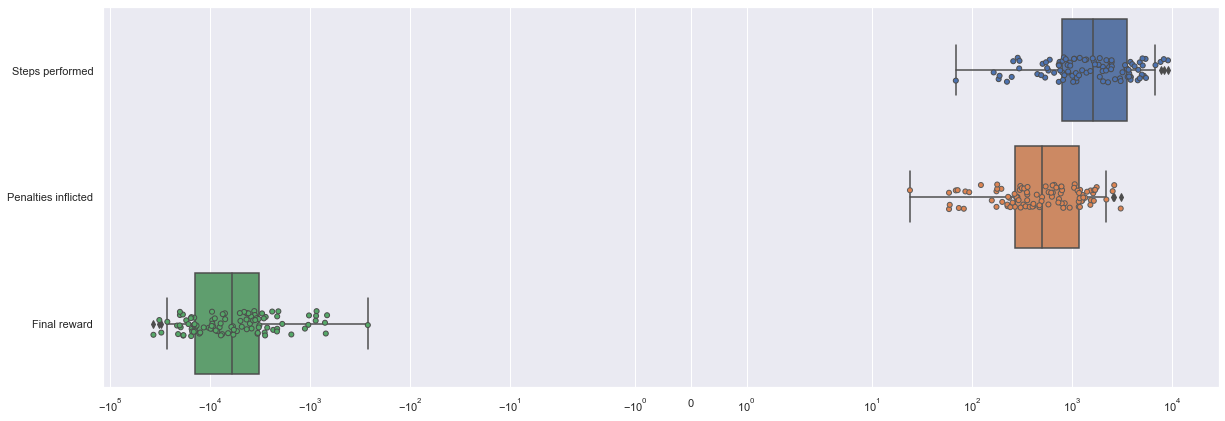

In [11]:
# Visualize aggregated results of the random search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
ax.set_xscale('symlog')
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1)
plt.show()

<a name="reinforcement-learning-tasks-two"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Try to interpret the visualization (e.g. the span of the boxes) and keep in mind, that the <i>x-axis</i> is scaled <i>logarithmically</i>.</li>
            <li>Which kind of information does a <i>random search</i> procedure <i>not</i> incorporate (<i>hint:</i> think in terms of <i>steps</i>)?</li>
            <li>Which kind of information would be necessary to be incorporated by an <i>RL algorithm</i> to be more efficient?</li>
        </ul>
</div>

<a name="reinforcement-learning-qlearning"></a><h2>Tackling the Environment with $Q$-Learning</h2>
<p>In a simplified version of $Q$-learning, the <b>$\boldsymbol{Q}$-value</b>
\begin{equation}
    Q(s,a)
\end{equation}</p>

<p>is the expected future reward of being in state $s$ and taking action $a$. Intuitively, if the $Q$-values are learned correctly, a good policy would be to take the action which maximizes the expected future reward. This is what $Q$-learning is doing. $Q$-learning lets the agent <b>use the environment's rewards to learn</b>, over time, the best action to take in a given state. $Q$-values are initialized to an arbitrary value, and as the agent exposes itself to the environment and receives different rewards by executing different actions, the $Q$-values are updated using the equation:
\begin{equation}
    Q(s_t,a_t) \leftarrow (1 - \alpha) \cdot Q(s_t,a_t) + \alpha \cdot \left( r_t + \gamma \max_{a_{t+1}} Q(s_{t+1}, a_{t+1})\right)
\end{equation}</p>

<p>We are assigning $\leftarrow$, or updating, the $Q$-value of the agent's current state and action, denoted as $Q(s_t,a_t)$ with $\alpha$ as the learning rate, i.e the extent to which our $Q$-values are being updated in every iteration.</p>

<p>The <b>$\boldsymbol{Q}$-table</b> is a matrix where we have a row for every state and a column for every action: $500$ and $6$, respectively, when referring to the current <i>Taxi-v3</i> example. It's first initialized to $0$, and then values are updated during training.</p>

<p>Previously, we talked about solving this task in a na&#xEF;ve way by simply applying <i>brute force</i> using <i>random search</i>. This time, we want to apply a more sophisticated algorithm, namely $Q$-learning:
<ul>
    <li><code>I</code> $\rightarrow$ Choose action $a_t$.</li>
    <li><code>II</code> $\rightarrow$ Go from state $s_t$ to state $s_{t+1}$ by taking action $a_{t}$.</li>
    <li><code>III</code> $\rightarrow$ For all possible $Q$-values from the state $s_{t+1}$, select the highest.</li>
    <li><code>IV</code> $\rightarrow$ Update $Q$-table values using the equation from above.</li>
    <li><code>V</code> $\rightarrow$ Set the next state as the current state and go back to <code>I</code> until a final state is reached (end of episode).</li>
</ul>

This procedure is repeated for as many episodes as specified (<code>VI</code>).</p>

In [12]:
def visualize_q_table(q_table: np.ndarray, title: str = '') -> None:
    """
    Visualize Q-table using a heatmap plot.
    
    :param q_table: Q-table to visualize
    """
    fig, ax = plt.subplots(figsize=(20, 7))
    sns.heatmap(data=q_table, ax=ax)
    ax.set(xlabel='Action', ylabel='State', title=title)
    display.clear_output(wait=True)
    display.display(fig)
    plt.close(fig=fig)


def apply_q_learning(environment: gym.Env, num_episodes: int = 1000, alpha: float = 0.1, gamma: float = 1.0,
                     animate: bool = False, delay_steps: int = 100) -> np.ndarray:
    """
    Solve specified environment by applying Q-learning.
    
    :param environment: the environment on which to apply Q-learning
    :param num_episodes: the total amount of episodes used to adapt the Q-table
    :param alpha: the learning rate to be applied by Q-learning
    :param gamma: the discount factor of future rewards
    :param animate: animate the Q-learning process
    :param delay_steps: the steps between each Q-table visualization (ignored if not animated)
    :return: adapted Q-table
    """
    q_table = np.zeros(shape=(environment.observation_space.n, environment.action_space.n))
    
    # <VI>: repeat Q-learning as long as the total amount of episodes is not yet reached.
    for episode in range(num_episodes):
        state, _ = environment.reset()
        
        done = False
        while not done:
            
            # <I>: choose next action according to current Q-table.
            action = np.argmax(q_table[state])
            
            # <II>: go from the current state to the next by applying chosen action.
            next_state, reward, terminated, truncated, _ = environment.step(action)
            done = terminated or truncated
            
            # <III>: from all possible Q-values w.r.t. the new state, select the highest.
            next_max = np.max(q_table[next_state])
            
            # <IV>: update the Q-table accordingly.
            old_value = q_table[state, action]
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            
            # <V>: update the next step with the current one.
            state = next_state
        
        # Optionally visualize the current Q-table.
        if animate and any(((episode + 1) % delay_steps == 0, (episode + 1) == num_episodes)):
            visualize_q_table(q_table=q_table, title=f'Episode {episode + 1}')
    
    return q_table

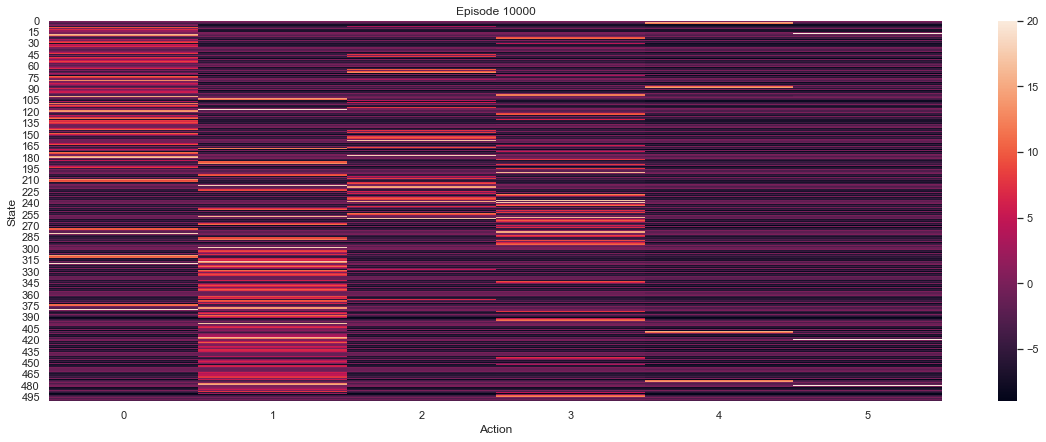

In [13]:
u6.set_environment_seed(environment=environment_taxi, seed=42)
q_table = apply_q_learning(
    environment=environment_taxi,
    num_episodes=10000,
    alpha=0.1,
    animate=True,
    delay_steps=1000
)

<a name="reinforcement-learning-qlearning-evaluation"></a><h3 style="color:rgb(0,120,170)">Evaluate the agent's performance</h3>

In [14]:
def apply_q_table(environment: gym.Env, q_table: np.ndarray, animate: bool = False,
                  delay: float = 0.01) -> Tuple[int, int, int]:
    """
    Solve specified environment by applying specified Q-table.
    
    :param environment: the environment on which to apply Q-table guided search
    :param q_table: the Q-table used during Q-table guided search
    :param animate: animate the Q-table guided search process
    :param delay: the minimum delay in milliseconds between each rendered frame (ignored if not animated)
    :return: amount of steps performed, penalties inflicted and final reward
    """
    num_steps, num_penalties, final_reward = 0, 0, 0
    
    # <III>: repeat Q-table guided search procedure as long as the episode is still ongoing.
    done = False
    while not done:
        
        # <I>: choose action according to the Q-table with respect to the current state.
        current_action = np.argmax(q_table[environment.s])
        
        # <II>: execute previously chosen action and transition into a new state.
        current_state, current_reward, terminated, truncated, _ = environment.step(current_action)
        done = terminated or truncated
        
        # Update counter for inflicted penalties.
        final_reward += current_reward
        if current_reward == -10:
            num_penalties += 1
        num_steps += 1
        
        # Optionally display current state.
        if animate:
            display.clear_output(wait=True)
            print(environment.render())
            print(f'Step No.: {num_steps}'
                  f'\nState ID: {current_state}'
                  f'\nAction ID: {current_action}'
                  f'\nReward: {current_reward}')
            time.sleep(delay)
    
    return num_steps, num_penalties, final_reward

In [15]:
u6.set_environment_seed(environment=environment_taxi, seed=42)
num_steps, num_penalties, final_reward = apply_q_table(
    environment=environment_taxi,
    q_table=q_table,
    animate=True,
    delay=0.25
)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step No.: 13
State ID: 410
Action ID: 5
Reward: 20


In [16]:
print(f'{num_steps} steps taken and {num_penalties} penalties inflicted'
      f' during searching the goal guided by a Q-table, with a final reward of {final_reward}.')

13 steps taken and 0 penalties inflicted during searching the goal guided by a Q-table, with a final reward of 8.


In [17]:
u6.set_environment_seed(environment=environment_taxi, seed=42)
num_steps_total, num_penalties_total, final_reward_total = [], [], []
num_repetitions = 100

# Collect information over multiple repetitions.
for repetition in range(num_repetitions):
    environment_taxi.reset()
    num_steps, num_penalties, final_reward = apply_q_table(environment=environment_taxi, q_table=q_table)
    num_steps_total.append(num_steps)
    num_penalties_total.append(num_penalties)
    final_reward_total.append(final_reward)

# Combine collected information to a data frame for further downstream analysis.
collected_experiment_info = pd.DataFrame({
    'Steps performed': num_steps_total,
    'Penalties inflicted': num_penalties_total,
    'Final reward': final_reward_total
})

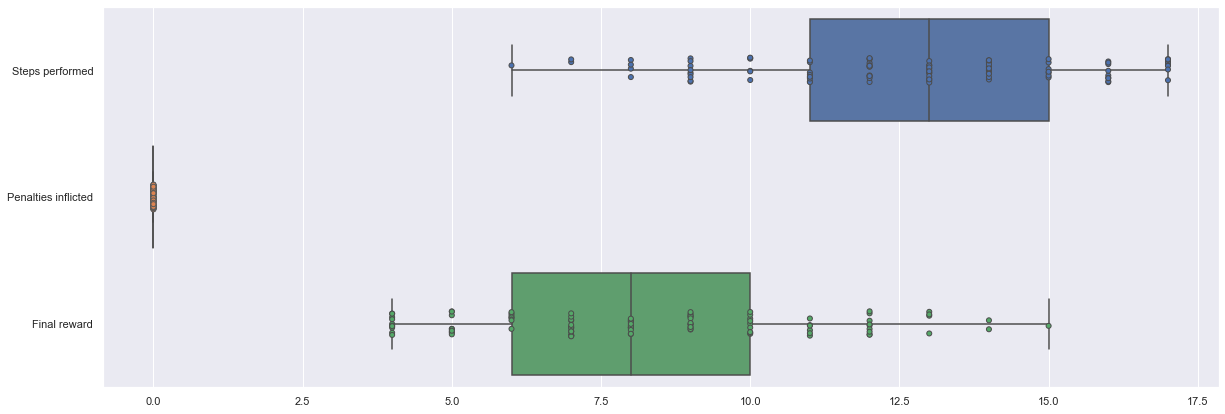

In [18]:
# Visualize aggregated results of the Q-table guided search procedure.
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=collected_experiment_info, ax=ax, orient='h')
sns.stripplot(data=collected_experiment_info, ax=ax, orient='h', linewidth=1)
plt.show()

<a name="reinforcement-learning-tasks-three"></a><h3 style="color:rgb(0,120,170)">Tasks</h3>
    <div class="alert alert-warning">
        Execute the notebook until here and try to solve the following tasks:
        <ul>
            <li>Try to interpret the visualization (e.g. the span of the boxes) and keep in mind, that the <i>x-axis</i> is <i>not</i> scaled logarithmically.</li>
            <li>Which kind of information does a <i>Q-table guided search</i> procedure incorporate (in contrast to e.g. a <i>random</i> one)?</li>
            <li>Compare the amount of steps performed with the numbers you got from the first task block. What do you observe?</li>
        </ul>
</div>